In [1]:
# Packages
using JuMP
using HiGHS
using CSV
using DataFrames
using Plots
using StatsPlots
using Printf

In [2]:
# include the helper functions
include("functions-to-import-data.jl");
include("functions-to-export-data.jl");
include("functions-to-plot-results.jl");

In [3]:
# include the file with the functions for the stochastic GEP model
include("Stochastic-GEP-two-stage-Benders-multicut.jl");

In [4]:
# Folders names
input_folder = joinpath(@__DIR__, "inputs/two-stage-3sc");
output_folder = joinpath(@__DIR__, "outputs/two-stage-Benders-3sc");

In [5]:
# read the data
sets, params = read_two_stage_data(input_folder);

In [6]:
first_stage_model = create_first_stage_model(sets, params)

A JuMP Model
Minimization problem with:
Variables: 7
Objective function type: AffExpr
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 7 constraints
`VariableRef`-in-`MathOptInterface.Integer`: 4 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: e_benders_cut, v_investment, v_theta

In [7]:
# Benders decomposition algorithm

# Define constants
MAXIMUM_ITERATIONS = 100       # maximum number of iterations
ABSOLUTE_OPTIMALITY_GAP = 1e-6 # gap between lower and upper bounds to stop the algorithm

# Define outputs
df_Benders_interations = DataFrame(;
    iteration=Int[],
    lower_bound=Float64[],
    upper_bound=Float64[],
    gap=Float64[],
)

df_investment_per_iteration = DataFrame(;
    iteration=Int[],
    generator=String[],
    investment=Float64[],
)

# Start Benders' Decomposition
upper_bound = Inf
println("Iteration  Lower Bound  Upper Bound          Gap")
for iteration in 1:MAXIMUM_ITERATIONS
    optimize!(first_stage_model)
    @assert is_solved_and_feasible(first_stage_model)
    lower_bound = objective_value(first_stage_model)
    p_investment = value.(first_stage_model[:v_investment])
    subproblem = create_and_solve_subproblem(sets, params, p_investment)
    upper_bound = minimum([upper_bound, objective_value(first_stage_model) - value.(first_stage_model[:e_benders_cut]) + value.(subproblem[:e_expected_cost])])
    gap = (upper_bound - lower_bound) / upper_bound
    push!(df_Benders_interations, (iteration, lower_bound, upper_bound, gap))
    print_iteration(iteration, lower_bound, upper_bound, gap)

    if gap < ABSOLUTE_OPTIMALITY_GAP
        println("Terminating with the optimal solution")
        break
    end
    add_cut(first_stage_model, subproblem, sets, params, p_investment, iteration)

    for g in sets[:G]
        push!(df_investment_per_iteration, (iteration, g, p_investment[g]))
    end
end

Iteration  Lower Bound  Upper Bound          Gap
        1  -1.0000e+03   1.5030e+06   1.0007e+00
        2   3.9000e+04   6.2448e+05   9.3755e-01
        3   1.3671e+05   5.3587e+05   7.4488e-01
        4   2.2836e+05   5.3587e+05   5.7385e-01
        5   2.4279e+05   2.8231e+05   1.4001e-01
        6   2.5982e+05   2.7278e+05   4.7493e-02
        7   2.6483e+05   2.7087e+05   2.2312e-02
        8   2.6767e+05   2.7087e+05   1.1841e-02
        9   2.6842e+05   2.6966e+05   4.5766e-03
       10   2.6871e+05   2.6966e+05   3.5205e-03
       11   2.6911e+05   2.6966e+05   2.0209e-03
       12   2.6914e+05   2.6927e+05   4.8487e-04
       13   2.6918e+05   2.6927e+05   3.3381e-04
       14   2.6924e+05   2.6924e+05   1.9457e-15
Terminating with the optimal solution


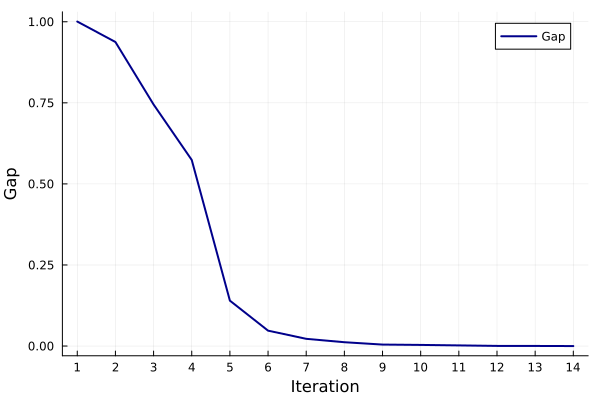

In [8]:
#plotly()
plot_gap(df_Benders_interations)

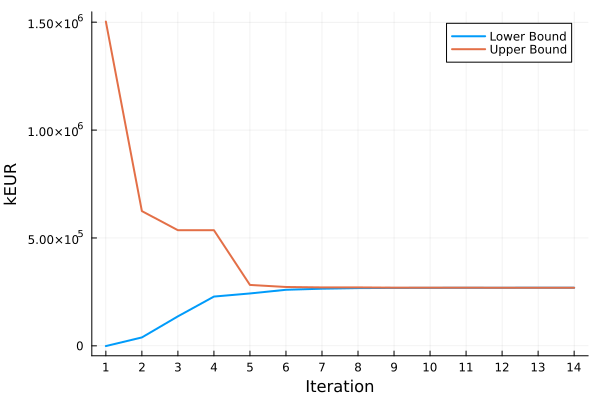

In [9]:
plot_bounds(df_Benders_interations)

In [10]:
optimize!(first_stage_model)
@assert is_solved_and_feasible(first_stage_model)
v_investment_optimal = value.(first_stage_model[:v_investment])

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, String7["ocgt", "ccgt", "wind", "solar"]
And data, a 4-element Vector{Float64}:
  0.0
  2.0
 35.0
 45.0

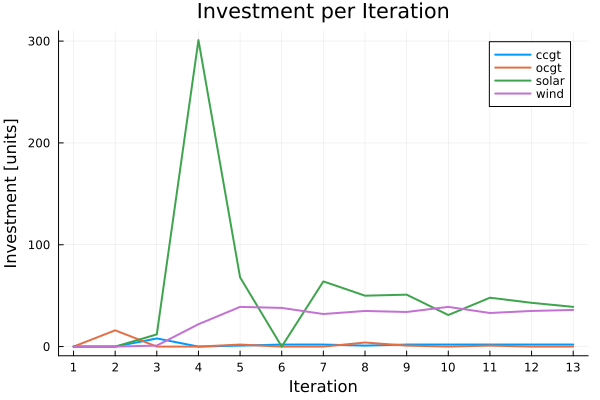

In [11]:
plot_investment_per_iteration(df_investment_per_iteration)

In [12]:
subproblem = create_and_solve_subproblem(sets, params, v_investment_optimal)

A JuMP Model
Minimization problem with:
Variables: 360
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 72 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 288 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 360 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 72 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: HiGHS
Names registered in the model: c_balance, c_max_prod, e_cost_per_scenario, e_ens_cost, e_expected_cost, e_variable_cost, v_ens, v_production

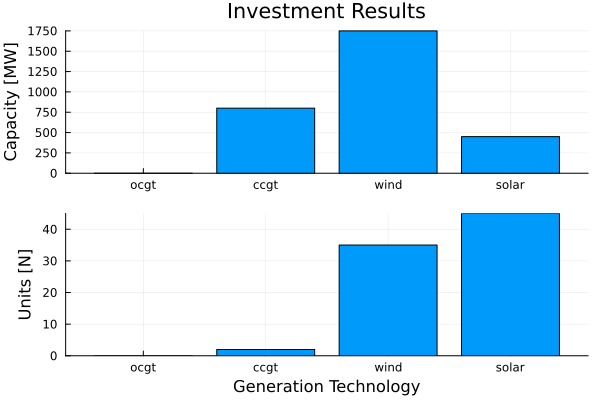

In [13]:
plot_two_stage_investment(first_stage_model, sets, params)

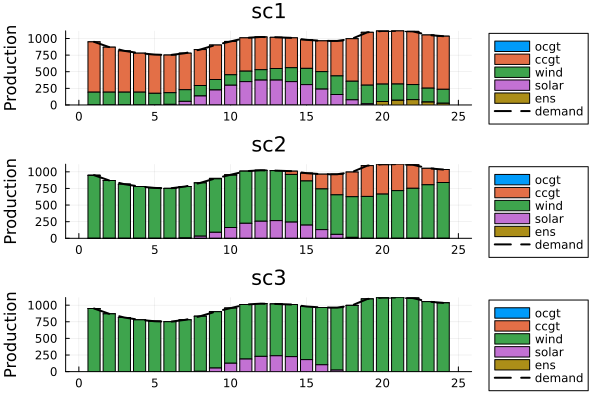

In [14]:
plot_two_stage_production(subproblem, params)

In [15]:
save_results_benders_first_stage_to_csv(output_folder, first_stage_model)
save_results_benders_subproblem_to_csv(output_folder, subproblem)

In [16]:
write_to_file(first_stage_model, "first_stage_model.lp")